In [1]:
import numpy as np
from scipy.stats import norm

from src.mcmc import RandomWalk, Barker, SMBarker, MALA, SMMALA, MMALA
from src.distribution import Rosenbrock, SmoothGeneralNormal, GeneralNormal
from src.utils.plot import traceplot, acfplot, rosenbrock_pairplot
from src.metrics import ks_distance, ad_distance, ess

In [2]:
class KLMC:
    def __init__(self):
        self.target = None
        self.n_var = None

        self.h = None
        self.gamma = None

        self.x = None
        self.v = None

        self.rng = None

    def initialize(self, initial_state):
        self.x = np.atleast_1d(initial_state)

        self.v = np.zeros_like(self.x)

        self.n_var = self.x.shape[0]

    def step(self):
        z = self.rng.normal(size=self.n_var)

        y = self.x + self.h * self.v

        self.v += (
            (self.h * self.target.d1_logpi(self.x))
            - (self.h * self.gamma * self.v)
            + (np.sqrt(2 * self.gamma * self.h) * z)
        )

        self.x = y

    def sample(
        self,
        target,
        initial_state=None,
        n_main_iter=5000,
        step_size=1,
        gamma=5,
        n_burnin_iter=5000,
        seed=2025,
    ):
        self.rng = np.random.default_rng(seed)

        self.target = target
        self.h = step_size
        self.gamma = gamma

        if initial_state is None:
            initial_state = np.zeros(target.n_var)
        self.initialize(initial_state)

        X_burnin = np.empty((self.n_var, n_burnin_iter))

        for i in range(n_burnin_iter):
            self.step()
            X_burnin[:, i] = self.x

        X_main = np.empty((self.n_var, n_main_iter))

        for i in range(n_main_iter):
            self.step()
            X_main[:, i] = self.x

        return {
            "trace_main": X_main,
            "trace_burnin": X_burnin,
        }

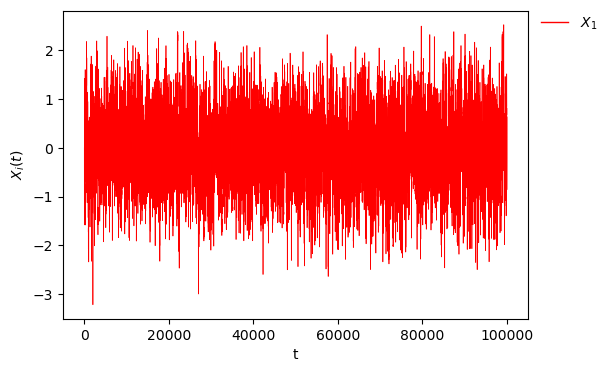

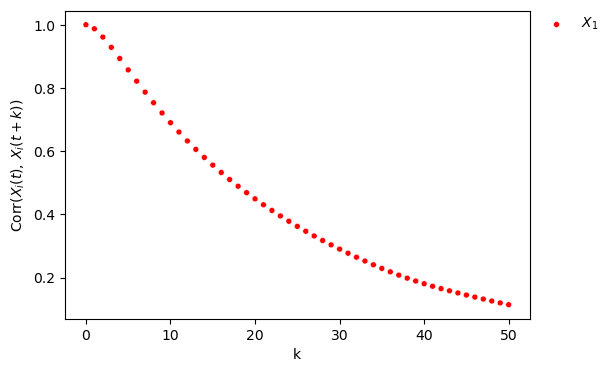

In [3]:
mcmc = KLMC()
target = GeneralNormal()

a = mcmc.sample(target, step_size=1e-1, gamma=5, n_main_iter=100000, n_burnin_iter=0)

traceplot(a["trace_main"])
acfplot(a["trace_main"])

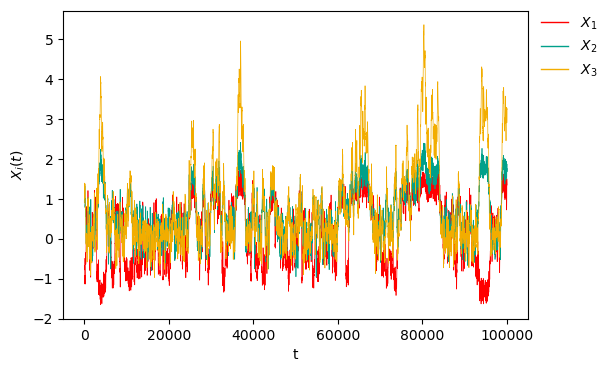

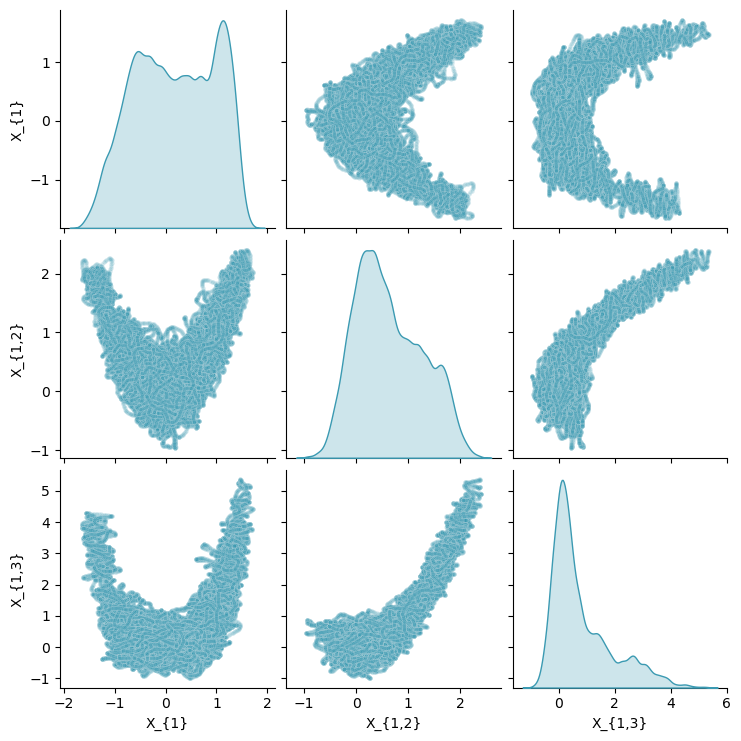

In [8]:
N1 = 3
N2 = 1
target = Rosenbrock(n1=N1, n2=N2)

mcmc = KLMC()

a = mcmc.sample(target, n_main_iter=100000, step_size=0.01, gamma=5)

traceplot(a["trace_main"])
# acfplot(a["trace_main"])

# ks_distance(a["trace_main"], target=target, verbose=True)
# ad_distance(a["trace_main"], target=target, verbose=True)
# ess(a["trace_main"], target=target, verbose=True)

rosenbrock_pairplot(a["trace_main"], n1=N1, n2=N2)